# Initialization

In [1]:
# append code repository to pythonpath

In [3]:
BASEDIR = '/axon/scratch/rfruengel/data/rm_paper_data/'

In [4]:
import sys
sys.path.append(BASEDIR + '/code')

In [3]:
# import from python ecosystem

In [5]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from functools import partial
import dask
from collections import defaultdict
from functools import partial
import distributed

In [6]:
%matplotlib inline

In [7]:
# import from this repository

In [8]:
from model_data_base import ModelDataBase
from model_data_base.plotfunctions.histogram import histogram
from model_data_base.plotfunctions.rasterplot import rasterplot
from model_data_base.analyze.temporal_binning import temporal_binning_pd

trying to connect to distributed locking server {'config': {'hosts': 'axon01:21811'}, 'type': 'zookeeper'}
success!


In [9]:
model = '2019-01-11_9330_AgsniKR_1_51_552'

In [10]:
# create a model data base (which holds intermediary data) in a temporary folder
mdb = ModelDataBase('/axon/scratch/rfruengel/testmdb')

In [10]:
# set up a dask cluster as described here: https://distributed.dask.org/en/stable/quickstart.html
client = distributed.Client('130.183.178.97:28786')
client

Client Scheduler: tcp://130.183.178.97:28786 Dashboard: http://130.183.178.97:28787/status,Cluster Workers: 20 Cores: 20 Memory: 2.00 TB


In [11]:
whiskers = ['B1', 'B2', 'B3', 'C1', 'C2', 'C3', 'D1', 'D2', 'D3', 'E2']

In [12]:
models = ['2019-01-11_9330_AgsniKR_1_51_552',
 '2019-01-26_12752_uvEXhHc_1_47_301',
 '2019-01-26_12752_uvEXhHc_4_113_409',
 '2019-02-11_9215_0Bx2rPx_5_171_390',
 '2019-02-23_7062_mvUlY5e_1_551_65',
 '2019-03-05_20241_SZ3iYOZ_707527054352652_109_665',
 '2019-05-10_15406_qBeBpVo_7712997831240842_108_441']

# Load multi-scale model simulation data

## Visualise MCM responses (optional)

In [29]:
model = '2019-01-11_9330_AgsniKR_1_51_552'

In [18]:
st = pd.read_csv(BASEDIR + "/{}/spike_times_MCM.csv".format(model))

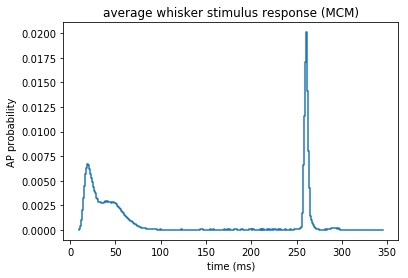

In [19]:
# the sensory stimulus was always applied at 245 ms
ax = plt.gca()
histogram(temporal_binning_pd(st), fig = ax)
plt.ylabel('AP probability')
plt.xlabel('time (ms)')
plt.title('average whisker stimulus response (MCM)')

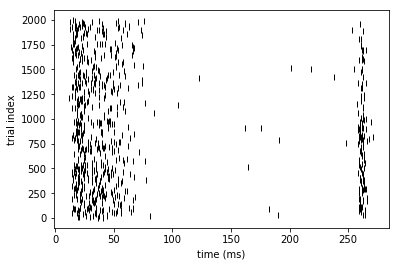

In [21]:
ax = plt.gca()
rasterplot(st[4000:6000], fig = ax)
plt.xlabel('time (ms)')
plt.ylabel('trial index')

## Spatiotemporal binning of synapse activations (pre-binned data is also provided)

In [8]:
import model_data_base.mdb_initializers.synapse_activation_binning

In [ ]:
import cloudpickle # compatible with version 0.2.2, other versions may work but have not been tested

In [6]:
# note: raw data is available on request, due to file size limits (~400GB per model)
model = '2019-01-11_9330_AgsniKR_1_51_552'

In [7]:
# create a model data base (which holds intermediary data) in a temporary folder
mdb = ModelDataBase('/axon/scratch/rfruengel/testmdb')

In [16]:
# load spike times into mdb
st = pd.read_csv(BASEDIR + "/{}/spike_times_MCM.csv".format(model))

st = st.set_index('sim_trail_index')

for whisker in whiskers:
    whisker_df = st[st.index.str[:2] == whisker]
    mdb.create_sub_mdb(whisker)
    mdb[whisker]['spike_times'] = whisker_df

In [267]:
BASEDIR + "/{}/synapse_activation_MCM_2_{}".format(model, whisker)

'/axon/scratch/rfruengel/data/rm_paper_data//2019-01-11_9330_AgsniKR_1_51_552/synapse_activation_MCM_2_E2'

In [15]:
# load synapse activations into mdb
for whisker in whiskers:
    path = BASEDIR + "/{}/synapse_activation_MCM_2_{}/Loader.pickle".format(model, whisker)
    with open(path) as f:  
        out = cloudpickle.load(f)
    sa = out.get(os.path.dirname(path))
    mdb[whisker]['synapse_activation'] = sa

loaded dask dataframe with index and known divisions
start deleting /axon/scratch/rfruengel/testmdb/b1_EzDK29_/mdb/synapse_activation_VgTD4w_
done deleting /axon/scratch/rfruengel/testmdb/b1_EzDK29_/mdb/synapse_activation_VgTD4w_
loaded dask dataframe with index and known divisions
start deleting /axon/scratch/rfruengel/testmdb/b2_BHu9V2_/mdb/synapse_activation_AcXAHE_
done deleting /axon/scratch/rfruengel/testmdb/b2_BHu9V2_/mdb/synapse_activation_AcXAHE_
loaded dask dataframe with index and known divisions
start deleting /axon/scratch/rfruengel/testmdb/b3_mTLayn_/mdb/synapse_activation_SeakTo_
done deleting /axon/scratch/rfruengel/testmdb/b3_mTLayn_/mdb/synapse_activation_SeakTo_
loaded dask dataframe with index and known divisions
start deleting /axon/scratch/rfruengel/testmdb/c1_WleMn5_/mdb/synapse_activation_r8X8d0_
done deleting /axon/scratch/rfruengel/testmdb/c1_WleMn5_/mdb/synapse_activation_r8X8d0_
loaded dask dataframe with index and known divisions
start deleting /axon/scratc

In [21]:
# bin synapse activations
for whisker in whiskers:
    model_data_base.mdb_initializers.synapse_activation_binning.init(mdb[whisker], 
                                        groupby = ['EI', 'binned_somadist'], 
                                        get = client.get)

## Load pre-binned synapse activations

In [15]:
model = '2019-01-11_9330_AgsniKR_1_51_552'
whisker = 'C2'

In [20]:
# each compressed numpy archive contains a single numpy array
sa = np.load(BASEDIR + "/{}/binned_synapse_activations_spatiotemporal_EI/{}.npz".format(model, whisker))
sa = sa['arr_0']

In [21]:
sa.shape # (excitatory/inhibitory, spatial bins, trials, temporal bins)

(2, 30, 81000, 400)

# Reduced model inference

## RaisedCosine basis functions

In [13]:
import modular_reduced_model_inference
from modular_reduced_model_inference import RaisedCosineBasis

In [14]:
RaisedCosineBasis_spatial = modular_reduced_model_inference.RaisedCosineBasis(a = 3, c = 5, phis = np.arange(3,12, 1.5), width = 30, reversed_ = False)
RaisedCosineBasis_temporal = modular_reduced_model_inference.RaisedCosineBasis(a = 2, c = 1, phis = np.arange(1,11, 0.5), width = 80, reversed_ = True)

In [15]:
import matplotlib.pyplot as plt

In [16]:
%matplotlib inline

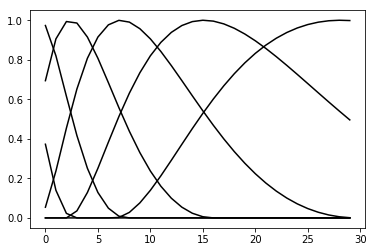

In [17]:
RaisedCosineBasis_spatial.visualize(plot_kwargs={'c': 'k', 'alpha': 1})

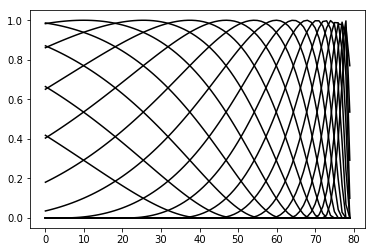

In [18]:
RaisedCosineBasis_temporal.visualize(plot_kwargs={'c': 'k', 'alpha': 1})

## Spatiotemporal filter inference

In [72]:
# we provide precomputed spatiotemporal filters for all models used in our paper
# which are visualized in the next section

In [73]:
whiskers

['B1', 'B2', 'B3', 'C1', 'C2', 'C3', 'D1', 'D2', 'D3', 'E2']

In [14]:
whiskers = ['C2']
# uncomment the following line to run inference on the whole dataset of the example model
# whiskers = ['B1', 'B2', 'B3', 'C1', 'C2', 'C3', 'D1', 'D2', 'D3', 'E2'] 
mdb_list = []
for whisker in whiskers:
    mdb_list.append(mdb[whisker])

name = 'test'
rm = modular_reduced_model_inference.Rm(name, 
    mdb = mdb_list[0], 
    tmin = 260, #timepoint_of_max_response
    tmax = 261, #timepoint_of_max_response+1
    width = 80)

# make simulation data available to the reduced model
D = modular_reduced_model_inference.DataExtractor_spatiotemporalSynapseActivation
k = 'synapse_activation_binned','t1','EI__binned_somadist'
rm.add_data_extractor('spatiotemporalSa', D(k))
rm.add_data_extractor('st', modular_reduced_model_inference.DataExtractor_spiketimes())
rm.add_data_extractor('y', modular_reduced_model_inference.DataExtractor_spikeInInterval())
rm.add_data_extractor('ISI', modular_reduced_model_inference.DataExtractor_ISI())

# define a strategy which evaluates simulation trials based on spatiotemporal filters
RaisedCosineBasis_spatial = RaisedCosineBasis(a = 3, c = 5, phis = np.arange(3,12, 1.5), width = 30, reversed_ = False)
RaisedCosineBasis_temporal = RaisedCosineBasis(a = 2, c = 1, phis = np.arange(1,11, 0.5), width = 80, reversed_ = True)
len_z = len(RaisedCosineBasis_spatial.phis) # number of parameters of the spatial filter
len_t = len(RaisedCosineBasis_temporal.phis)  # number of parameters of the temporal filter
strategy = modular_reduced_model_inference.Strategy_spatiotemporalRaisedCosine('SAspatiotemporalRaisedCosine', RaisedCosineBasis_spatial, RaisedCosineBasis_temporal)

rm.add_strategy(strategy)

# add solver
solver = modular_reduced_model_inference.Solver_COBYLA('cobyla')
strategy.add_solver(solver)

for lv in range(3): # make 3 random train/test splits
    # rm.DataSplitEvaluation.add_random_split('.7_{}'.format(lv), percentage_train=.7)
    rm.DataSplitEvaluation.add_isi_dependent_random_split('ISI50_.7_{}'.format(lv),min_isi = 50, percentage_train=.7)

for lv in range(3):
    rm.run(client)

In [51]:
result_df = rm.get_results(client)
# If you get ValueError: Only one class present in y_true. ROC AUC score is not defined in that case, it means that the
# reduced model failed (this happens for example due to a lack of spikes in the interval used for inference)

In [65]:
parameters = strategy.convert_x(result_df.iloc[0].x)

In [74]:
result_df

score success  \
strategy                     solver split subsplit run                     
SAspatiotemporalRaisedCosine cobyla .7_0  subtest1 0   -0.996870    True   
                                                   1   -0.997291    True   
                                                   2   -0.997236    True   
                                          subtest2 0   -0.988947    True   
                                                   1   -0.988780    True   
                                                   2   -0.988945    True   
                                          test     0   -0.993215    True   
                                                   1   -0.993173    True   
                                                   2   -0.993307    True   
                                          train    0   -0.980095    True   
                                                   1   -0.980399    True   
                                                   2   -0.980262    True   
                                    .7_1  subtest1 0   -0.997529    True   
                                                   1   -0.997401    True   
                                                   2   -0.996980    True   
                                          subtest2 0   -0.989935    True   
                                                   1   -0.989839    True   
                                                   2   -0.987818    True   
                                          test     0   -0.993939    True   
                                                   1   -0.993797    True   
                                                   2   -0.992584    True   
                                          train    0   -0.980206    True   
                                                   1   -0.980435    True   
                                                   2   -0.979045    True   
                                    .7_2  subtest1 0   -0.997465    True   
                                                   1   -0.997044    True   
                                                   2   -0.997273    True   
                                          subtest2 0   -0.989367    True   
                                                   1   -0.989219    True   
                                                   2   -0.989864    True   
                                          test     0   -0.993602    True   
                                                   1   -0.993368    True   
                                                   2   -0.993819    True   
                                          train    0   -0.979776    True   
                                                   1   -0.980421    True   
                                                   2   -0.979452    True   

                                                                                                        x  
strategy                     solver split subsplit run                                                     
SAspatiotemporalRaisedCosine cobyla .7_0  subtest1 0    [-1.04462191284, 3.50959094907, 0.155951405528...  
                                                   1    [1.32387044124, 2.25542916606, 1.2730504114, -...  
                                                   2    [0.677757637744, 1.88620861437, 0.438142337144...  
                                          subtest2 0    [-1.04462191284, 3.50959094907, 0.155951405528...  
                                                   1    [1.32387044124, 2.25542916606, 1.2730504114, -...  
                                                   2    [0.677757637744, 1.88620861437, 0.438142337144...  
                                          test     0    [-1.04462191284, 3.50959094907, 0.155951405528...  
                                                   1    [1.32387044124, 2.25542916606, 1.2730504114, -...  
                                                   2    [0.677757637744, 1.88620861437, 0.

### Visualize spatiotemporal filters

In [167]:
RaisedCosineBasis_spatial = RaisedCosineBasis(a = 3, c = 5, phis = np.arange(3,12, 1.5), width = 30, reversed_ = False)
RaisedCosineBasis_temporal = RaisedCosineBasis(a = 2, c = 1, phis = np.arange(1,11, 0.5), width = 80, reversed_ = True)
strategy = modular_reduced_model_inference.Strategy_spatiotemporalRaisedCosine('SAspatiotemporalRaisedCosine', RaisedCosineBasis_spatial, RaisedCosineBasis_temporal)
# manually do what happens in rm.add_strategy(strategy)
# this avoids having to load in the dataset
strategy.len_z = len(RaisedCosineBasis_spatial.phis) # number of parameters of the spatial filter
strategy.len_t = len(RaisedCosineBasis_temporal.phis)  # number of parameters of the temporal filter
strategy.groups = [('EXC',), ('INH',)] # excitatory and inhibitory
strategy.convert_x = partial(strategy._convert_x_static, groups, len_z)

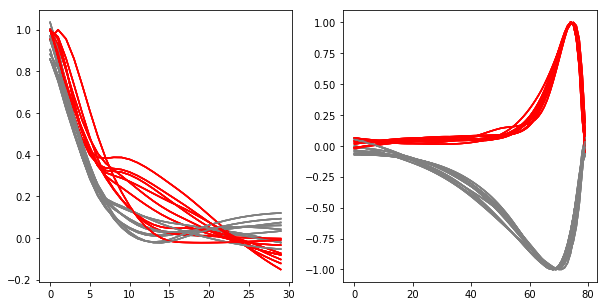

In [168]:
# the reduced model filters have one unconstrained parameter: they can be multiplied by a scalar
# normalize such that excitatory weight in the spatial filter at soma distance 0 is 1
strategy.visualize(result_df, normalize = True)

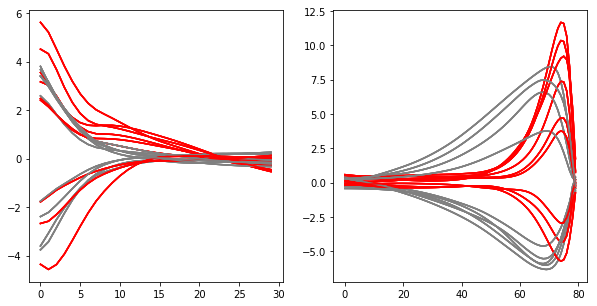

In [169]:
# visualize models before normalization
strategy.visualize(result_df, normalize = False)

In [171]:
# get numerical values of kernels visualized above
index_best_model = result_df.score.argmin()
spatiotemporal_filters = strategy.get_kernel_dict(result_df.loc[index_best_model].x, normalize = True)
spatiotemporal_filters

{'s_exc': array([  1.00000012e+00,   9.65586007e-01,   8.62986445e-01,
          7.36628532e-01,   6.05339050e-01,   4.82981980e-01,
          3.78825486e-01,   2.96598017e-01,   2.36139476e-01,
          1.85714200e-01,   1.41483724e-01,   1.04197599e-01,
          7.40506127e-02,   5.08730039e-02,   3.42659317e-02,
          2.36965008e-02,   1.85634978e-02,   1.62135474e-02,
          1.39226858e-02,   1.17193200e-02,   9.63044725e-03,
          7.67565984e-03,   5.86846564e-03,   4.21742443e-03,
          2.72710342e-03,   1.39888562e-03,   2.31627375e-04,
         -7.77784735e-04,  -1.63397053e-03,  -2.34268326e-03], dtype=float32),
 's_inh': array([ 1.03528202,  0.90689689,  0.73187381,  0.5653078 ,  0.42378673,
         0.31251875,  0.23399325,  0.1861264 ,  0.16250817,  0.14565614,
         0.12962659,  0.11495598,  0.1019618 ,  0.09080301,  0.08152636,
         0.07410123,  0.06844527,  0.06327607,  0.05724808,  0.05057602,
         0.04345042,  0.03603527,  0.02847028,  0.020

## Calculate WNI values with spatiotemporal filters

In [177]:
def get_spatial_bin_level(key):
    '''returns the index that reflects the spatial dimension'''
    return key[-1].split('__').index('binned_somadist')

def get_sorted_keys_by_group(mdb, key, group):
        '''returns keys sorted such that the first key is the closest to the soma'''       
        group = list(group)
        level = get_spatial_bin_level(key)
        keys = mdb[key].keys()
        keys = sorted(keys, key = lambda x: float(x[level].split('to')[0]))
        out = []
        for k in keys:
            k_copy = list(k[:])
            k_copy.pop(level)
            if k_copy == group:
                out.append(k)
        return out

def _get_spatiotemporal_input(mdb, key, group):
    keys = get_sorted_keys_by_group(mdb, key, group)
    out = [mdb[key][k] for k in keys]
    print keys
    return out

In [184]:
# calculate all the WNI values at relevant timepoints - we will need them again to estimate the ISI-dependent penalty
@dask.delayed
def calculate_WNI_values(m,kernel_dict, model, whisker, outdir):
    n_cells = len(m['spike_times'])
    timebins = len(range(220, 271))
    
    WNI_df = pd.DataFrame(index = range(n_cells), columns = range(220, 271))

    SAexc = _get_spatiotemporal_input(m, 
                                      ('synapse_activation_binned', 't1', 'EI__binned_somadist'),
                                      ['EXC'])

    SAinh = _get_spatiotemporal_input(m, 
                                      ('synapse_activation_binned', 't1', 'EI__binned_somadist'),
                                      ['INH'])
    
    SAexc = np.asarray(SAexc)
    SAinh = np.asarray(SAinh)
    
    s_exc = kernel_dict['s_exc']
    s_inh = kernel_dict['s_inh']
    t_exc = kernel_dict['t_exc']
    t_inh = kernel_dict['t_inh']

   

    SAinh_cumulative = np.ndarray((n_cells, 400))
    SAexc_cumulative = np.ndarray((n_cells, 400))

    for t, timebin in enumerate(range(220-80, 271)): # for all timebins relevant to period of interest
        ## get excitatory and inhibitory input, spatially binned for the CURRENT timebin
        SAexc_timebin = SAexc[:, :, timebin]
        SAinh_timebin = SAinh[:, :, timebin]

        ## apply spatial kernel to the current timebin
        SAexc_timebin = sum([o*s for o, s in zip(SAexc_timebin, s_exc)])
        SAinh_timebin = sum([o*s for o, s in zip(SAinh_timebin, s_inh)])



        for cell in range(n_cells):
            SAinh_cumulative[cell][timebin] = SAinh_timebin[cell]
            SAexc_cumulative[cell][timebin] = SAexc_timebin[cell]



    ## apply temporal kernel to timebins of interest
    for t, timebin in enumerate(range(220, 271)):
#         print timebin
        for cell in range(n_cells):

            SAexc_window = SAexc_cumulative[cell][timebin-79:timebin+1]
            SAinh_window = SAinh_cumulative[cell][timebin-79:timebin+1]



            SAexc_window = sum([o*s for o, s in zip(SAexc_window, t_exc)])
            SAinh_window = sum([o*s for o, s in zip(SAinh_window, t_inh)])

            ## get weighted net input for each cell
            WNI = SAexc_window + SAinh_window
            WNI_df.iloc[cell, t] = WNI
    name = '{}__{}'.format(model, whisker)
    WNI_df.to_csv(outdir.join(name))

In [180]:
outdir = mdb.create_managed_folder('outdir_WNI', raise_ = False)

/axon/scratch/rfruengel/project_src/in_silico_framework/model_data_base/model_data_base.py:526: UserWarning: The database source folder has uncommitted changes!
  warnings.warn('The database source folder has uncommitted changes!')


In [190]:
delayeds = []
index = []

for whisker in whiskers:   
    m = mdb[whisker]
    d = calculate_WNI_values(m, spatiotemporal_filters, '2019-01-11_9330_AgsniKR_1_51_552', whisker, outdir)
    delayeds.append(d)
    index.append(('2019-01-11_9330_AgsniKR_1_51_552', whisker))

In [192]:
# to prevent memory issues - each worker will load around 25GB of data
# adjust the number of cores working per node according to your memory limits
workers_per_node = 5
from itertools import groupby
workers = client.scheduler_info()['workers'].keys()
workers = sorted(workers, key = lambda x: x.split(':')[1])
w = [list(w)[:workers_per_node] for group, w in groupby(workers, lambda x: x.split(':')[1])]
w = [w for w in w for w in w]

In [194]:
futures = client.compute(delayeds, workers=w)

## Nonlinearity

In [207]:
def group_bins(helper_df, min_items = 10):
    # https://codereview.stackexchange.com/questions/12753/taking-the-first-few-items-of-a-list-until-a-target-sum-is-exceeded/12759

    total_items = 0
    rows_to_group = []
    groupings = []

    for row in range(len(helper_df.index)):

        items = helper_df.iloc[row, 3]
        total_items += items # keep a running total of number of datapoints
        rows_to_group.append(row)

        if total_items >= min_items: # once we have enough datapoints, save the grouping and continue
            total_items = 0
            groupings.append(rows_to_group)
            rows_to_group = []

        elif row == range(len(helper_df.index))[-1]: # or if it's the last bin, which might get skipped otherwise 
            groupings.append([row])

    # check if the last bin is too small, merge with second to last if it is
    last_binsize = 0
    for row in groupings[-1]:
        last_binsize += helper_df.iloc[row, 3]

    if last_binsize < min_items:
        new_grouping = groupings[:-2]
        last_bins = groupings[-2:]
        new_grouping.append([i for sublist in last_bins for i in sublist])
        groupings = new_grouping
    
    return groupings

def signchange(x,y):
    if x / abs(x) == y / abs(y):
        return False
    else:
        return True

def linear_interpolation_between_pairs(X,Y, x, top = 'inf', bottom = 'min'):
    if x > max(X):
        if top == 'inf':
            result = np.inf
        elif top == 'max':
            result = max(Y)
    elif x < min(X):
        if bottom == 'inf':
            result = -np.inf
        elif bottom == 'min':
            result = min(Y)        
    elif float(x) in X: # don't need to interpolate, causes assertion error
        result = Y[X.index(x)]
    else:
        pair = [lv for lv in range(len(X)-1) if signchange(X[lv]-x, X[lv+1]-x)]
#         X[lv] <= x < X[lv + 1]]
        assert(len(pair) == 1)
        pair = pair[0]
        m = (Y[pair+1]-Y[pair]) / (X[pair+1]-X[pair])
        c = Y[pair]-X[pair]*m

        result = m*x+c
    return result

def variable_stepsize_nonlinearity(wni_values, spike_times, spike_before = None, lookup_series_stepsize = 3, min_items = 10):
    pdf2 = pd.DataFrame(dict(wni_values = wni_values, spike = spike_times))
    if spike_before is not None:
        pdf = pdf2[~spike_before]
    else:
        pdf = pdf2

    bins = range(int(np.floor(pdf['wni_values'].min())), int(np.floor(pdf['wni_values'].max())) + lookup_series_stepsize + 1, lookup_series_stepsize)
    pdf['bin'] = pd.cut(pdf['wni_values'], bins, include_lowest=True)

    helper_df = pd.DataFrame()

    edges = []
    spike_prob = []
    n_items = []
    spikes = []
    for b in set(pdf['bin']):
        b_pdf = pdf[pdf['bin'] == b]
        n_items.append(len(b_pdf))
        edges.append(int(b.split(',')[0][1:]))
        spike_prob.append(np.mean(b_pdf['spike']))
        spikes.append(list(b_pdf['spike']))

    helper_df['bin_start'] = edges
    helper_df['spike_prob'] = spike_prob
    helper_df['spikes'] = spikes
    helper_df['n_items'] = n_items
    helper_df.sort_values('bin_start', inplace = True)

    bin_groupings = group_bins(helper_df, min_items = min_items)
    new_df = pd.DataFrame(columns = ['bin_start', 'spike_prob'], index = range(len(bin_groupings)))

    bin_starts = []
    spike_probs = []
    for g in bin_groupings:
        if len(g) == 1:
            bin_starts.append(helper_df.iloc[g[0], 0])
            spike_probs.append(helper_df.iloc[g[0], 1])
        else:
            bin_starts.append(helper_df.iloc[g[0], 0])
            spikes = []
            for row in g:
                spikes.append(helper_df.iloc[row, 2])

            spikes = [i for sublist in spikes for i in sublist]
            assert len(spikes) >= min_items
            spike_probs.append(np.mean(spikes))


    points = []
    for n, b in enumerate(bin_starts):
        midpoint = b + (lookup_series_stepsize * len(bin_groupings[n]))/2.
        points.append((midpoint, spike_probs[n]))

    points = sorted(points)
    x_points = [p[0] for p in points]
    y_points = [p[1] for p in points]

    diff = max(x_points) - min(x_points)
    index = np.arange(int(min(x_points) - 0.3 * diff), int(max(x_points) + 0.3 * diff))

    LUT = pd.Series(index = index)
    for i in index:
        LUT[i] = linear_interpolation_between_pairs(x_points,y_points, i, top = 'max')
        
    return LUT

In [209]:
from model_data_base.analyze.spike_detection import spike_in_interval

In [219]:
rm_inference_timepoint = 260
WNI_df = []
spike_times_df = []
for whisker in whiskers:
    spike_times_df.append(mdb[whisker]['spike_times'])

    key = '{}__{}'.format('2019-01-11_9330_AgsniKR_1_51_552', whisker)
    WNI_df.append(pd.read_csv(mdb['outdir_WNI'].join(key)))
    
WNI_df = pd.concat(WNI_df)
spike_times_df = pd.concat(spike_times_df)


tdf = WNI_df.loc[:, str(rm_inference_timepoint)]
wni_values = np.asarray(tdf)
spike_times = np.asarray(spike_in_interval(spike_times_df, rm_inference_timepoint, rm_inference_timepoint + 1)) 
assert len(wni_values) == len(spike_times)

rp = 15 # filter out trials with a spike in the last X ms
spike_before =  np.asarray(spike_in_interval(spike_times_df, rm_inference_timepoint - rp, rm_inference_timepoint))

nonlinearity = variable_stepsize_nonlinearity(wni_values, spike_times, spike_before = spike_before)

/axon/scratch/rfruengel/anaconda2_isf/lib/python2.7/site-packages/ipykernel/__main__.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


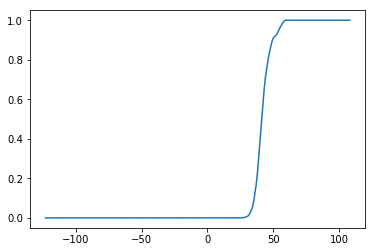

In [221]:
plt.plot(nonlinearity)

## ISI-dependent penalty

In [228]:
def fetch_ISI_WNI_data(model, rm_inference_timepoint):
    st = pd.concat([mdb[whisker]['spike_times'] for whisker in whiskers])
    # is there a spike in the estimation period?
    st['spike_in_interval'] = spike_in_interval(st, rm_inference_timepoint, rm_inference_timepoint + 1)
    # how long ago was the most recent spike?
    st[st>rm_inference_timepoint] = np.NaN
    st['ISI'] = st.max(axis=1) - rm_inference_timepoint

    # collect WNI values and add them to the dataframe
    wni = pd.DataFrame()
    for whisker in whiskers:
        wni_path = mdb['outdir_WNI'].join('{}__{}'.format(model, whisker))
        wni = pd.concat([wni, pd.read_csv(wni_path)])

    st['wni_value'] = np.asarray(wni.loc[:, str(rm_inference_timepoint)])
    

    spike_df = st[st.spike_in_interval & (st.ISI > -80) & (st.ISI < 0)]
    no_spike_df = st[~st.spike_in_interval & (st.ISI > -80) & (st.ISI < 0)]
    
    spike_isi = spike_df['ISI']
    spike_wni = spike_df['wni_value']
    
    no_spike_isi = no_spike_df['ISI']
    no_spike_wni = no_spike_df['wni_value']

    return spike_isi, spike_wni, no_spike_isi, no_spike_wni, st

In [234]:
def get_isi_boundary_95(spike_isi, spike_wni):
    def signchange(x,y):
        if x / abs(x) == y / abs(y):
            return False
        else:
            return True
    
    def linear_interpolation_between_pairs(X,Y, x):
        if x > max(X):
            result = np.inf
        elif x < min(X):
            result = min(Y)
        elif float(x) in X: # don't need to interpolate, causes assertion error
            result = Y[X.index(x)]
        else:
            pair = [lv for lv in range(len(X)-1) if signchange(X[lv]-x, X[lv+1]-x)]
    #         X[lv] <= x < X[lv + 1]]
            assert(len(pair) == 1)
            pair = pair[0]
            m = (Y[pair+1]-Y[pair]) / (X[pair+1]-X[pair])
            c = Y[pair]-X[pair]*m

            result = m*x+c
        return result
    
    l = zip(spike_isi, spike_wni)
    if len(l) < 2:
        return I.np.nan
    l = sorted(l, key = lambda x: x[1]) # sort by WNI values
    to_drop = len(spike_wni) / 20 # drop lowest 5%
    l = l[to_drop:]
    
    l = sorted(l, key = lambda x: x[0], reverse = True) # sort by ISI again
    
    points = []
    points.append([l[0][0], l[0][1]])
    y_min = l[0][1]
    for x, y in l:
        if y < y_min:
            points.append([x, y])
            y_min = y
            
    x_points = [p[0] for p in points]
    y_points = [p[1] for p in points]

    ISI_boundary = pd.Series(index = range(-80, 0))

    for ISI in ISI_boundary.index:
        ISI_boundary[ISI] = linear_interpolation_between_pairs(x_points, y_points, ISI)
        
    return ISI_boundary

In [230]:
spike_isi, spike_wni, no_spike_isi, no_spike_wni, st = fetch_ISI_WNI_data('2019-01-11_9330_AgsniKR_1_51_552', rm_inference_timepoint)

In [235]:
ISI_penalty = get_isi_boundary_95(spike_isi, spike_wni)

In [236]:
def plot_ISI_cloud(ax, spike_isi, spike_wni, no_spike_isi, no_spike_wni, s = 2):
    ax.scatter(no_spike_isi, no_spike_wni, c = 'k', s = s, rasterized = True)
    ax.scatter(spike_isi, spike_wni, c = 'r', s = s, rasterized = True)
    ax.legend(['no spike', 'spike'])
    ax.set_xlim(-85, 5)
    ax.set_ylim(-30, 120)
    ax.set_xlabel('inter spike interval (ms)')
    ax.set_ylabel('weighted net input')

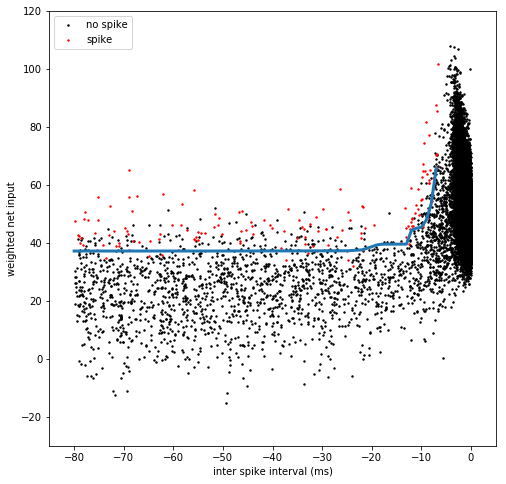

In [241]:
fig = plt.figure(figsize = (8,8))
ax = plt.gca()
plot_ISI_cloud(ax, spike_isi, spike_wni, no_spike_isi, no_spike_wni)
plt.plot(ISI_penalty, linewidth = 3)

In [242]:
# when using the ISI-dependent penalty for simulations, you should subtract the baseline value, i.e.
ISI_penalty_simulations = ISI_penalty - min(ISI_penalty)

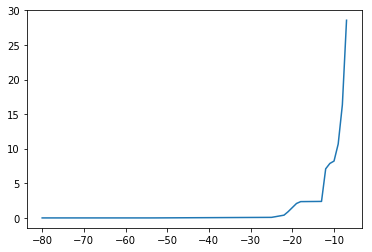

In [243]:
plt.plot(ISI_penalty_simulations)

# Reduced model simulations

In [244]:
import json
import seaborn as sns

In [245]:
# load reduced models which we provide, or use ones that you generated above
rm_dict = {}
for model in models:
    with open("/axon/scratch/rfruengel/data/rm_paper_data/{}/reduced_model_parameters.txt".format(model), "r") as fp:
        rm = json.load(fp)
    rm_dict[model] = rm

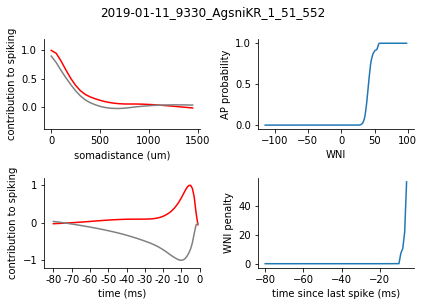

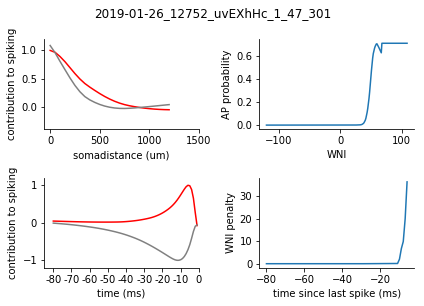

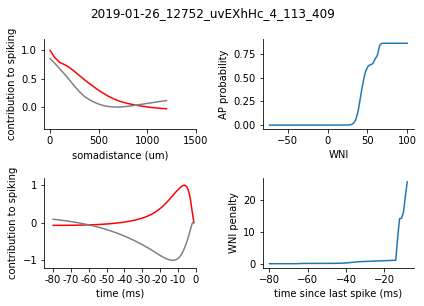

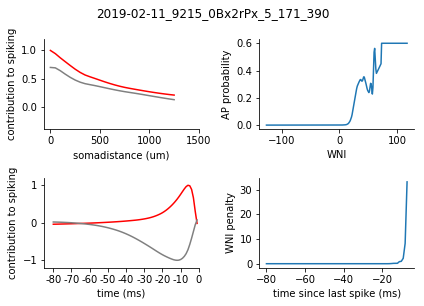

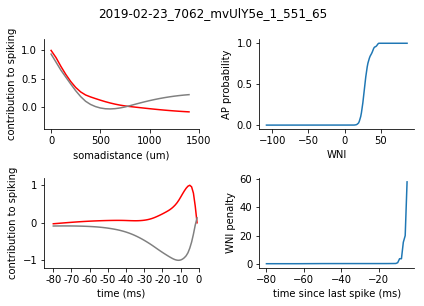

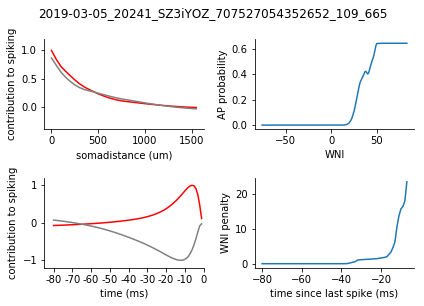

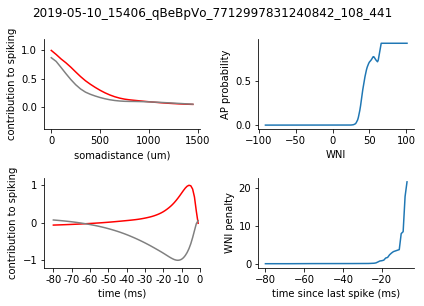

In [246]:
for model in models:
    fig = plt.figure()
    plt.suptitle(model, y = 1.05)

    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,3)
    filters = rm_dict[model]['spatiotemporal_filters']
    s_exc = filters['s_exc']
    s_inh = filters['s_inh']
    t_exc = filters['t_exc']
    t_inh = filters['t_inh']

    ax1.plot(s_exc, c = 'r')
    ax1.plot(s_inh, c = 'grey')
    ax1.set_xticks([0,10,20, 30])
    ax1.set_xticklabels([0, 500, 1000, 1500])
    ax1.set_xlabel('somadistance (um)')

    ax2.plot(t_exc, c = 'r')
    ax2.plot(t_inh, c = 'grey')
    ax2.set_xticks(range(0, 85, 10))
    ax2.set_xticklabels(range(-80, 5, 10))
    ax2.set_xlabel('time (ms)')

    ax1.set_ylim(-0.4, 1.2)
    ax2.set_ylim(-1.2, 1.2)
    ax1.set_ylabel('contribution to spiking')
    ax2.set_ylabel('contribution to spiking')
    ax2.set_xlim(-5, 80)
    
    nonlinearity = pd.Series(rm_dict[model]['nonlinearity'])
    nonlinearity.index = nonlinearity.index.astype(int)
    nonlinearity = nonlinearity.sort_index()
    ax3 = fig.add_subplot(2,2,2)
    ax3.plot(nonlinearity)
    ax3.set_ylabel('AP probability')
    ax3.set_xlabel('WNI')

    penalty = pd.Series(rm_dict[model]['ISI_penalty'])
    penalty.index = penalty.index.astype(int)
    penalty = penalty.sort_index()
    ax4 = fig.add_subplot(2,2,4)
    ax4.plot(penalty)
    ax4.set_ylabel('WNI penalty')
    ax4.set_xlabel('time since last spike (ms)')
        
    plt.tight_layout()
    sns.despine()
    plt.show()

In [250]:
class ReducedModel:
    def __init__(self, kernel_dict, LUT, ISI_penalty, spatial_bin_size = 50):
        self.kernel_dict = kernel_dict
        self.LUT = LUT
        self.ISI_penalty = ISI_penalty
        self.spatial_bin_size = spatial_bin_size

    def run(self, SAexc, SAinh, return_WNI = False):
        '''Apply the reduced model to synaptic input to get a list containing output spike times.
        SAexc, SAinh: numpy arrays containing spatiotemporally binned synaptic inputs, shape (spatial bins, trials, temporal bins)
        return_WNI: bool
            full_trace returns a dataframe containing WNI values at all timepoints along with spike times. 
            False returns spike times dataframe only.'''
        s_exc = self.kernel_dict['s_exc']
        s_inh = self.kernel_dict['s_inh']
        t_exc = self.kernel_dict['t_exc']
        t_inh = self.kernel_dict['t_inh']
        
        assert SAexc.shape == SAinh.shape

        LUT = self.LUT

        WNI_boundary = self.ISI_penalty
        
        spatial_bins = SAexc.shape[0]
        n_trials = SAexc.shape[1]
        timebins = SAexc.shape[2]
        
        WNI_df = pd.DataFrame(index = range(n_trials), columns = range(timebins))

        SAinh_cumulative = np.zeros((n_trials, timebins))
        SAexc_cumulative = np.zeros((n_trials, timebins))

        spike_times_df = pd.DataFrame(index = range(n_trials))

        for timebin in range(timebins):
            ## get excitatory and inhibitory input, spatially binned for the CURRENT timebin
            SAexc_timebin = np.ndarray((spatial_bins, n_trials, 1))
            for dist in range(spatial_bins):
                for cell in range(n_trials):
                    SAexc_timebin[dist][cell] = SAexc[dist][cell][timebin]

            SAinh_timebin = np.ndarray((spatial_bins, n_trials, 1))
            for dist in range(spatial_bins):
                for cell in range(n_trials):
                    SAinh_timebin[dist][cell] = SAinh[dist][cell][timebin]

            ## apply spatial kernel to the current timebin
            SAexc_timebin = sum([o*s for o, s in zip(SAexc_timebin, s_exc)])
            SAinh_timebin = sum([o*s for o, s in zip(SAinh_timebin, s_inh)])



            for cell in range(n_trials):
                SAinh_cumulative[cell][timebin] = SAinh_timebin[cell]
                SAexc_cumulative[cell][timebin] = SAexc_timebin[cell]



            ## apply temporal kernel
            spikes = []
            for cell in range(n_trials):
                if timebin - 80 >= 0:
                    SAexc_window = SAexc_cumulative[cell][timebin-79:timebin+1]
                    SAinh_window = SAinh_cumulative[cell][timebin-79:timebin+1]
                else:
                    SAexc_window = SAexc_cumulative[cell][0:timebin+1]
                    SAinh_window = SAinh_cumulative[cell][0:timebin+1]


                SAexc_window = sum([o*s for o, s in zip(SAexc_window, t_exc[-len(SAexc_window):])])
                SAinh_window = sum([o*s for o, s in zip(SAinh_window, t_inh[-len(SAinh_window):])])

                ## get weighted net input for each cell
                WNI = SAexc_window + SAinh_window
                WNI_df.iloc[cell, timebin] = WNI

                # check the last 80 bins for a spike, apply WNI penalty if there was
                min_index = 0 if timebin < 80 else timebin-80
                if sum(spike_times_df.iloc[cell, min_index:timebin]) > 0: #if there was a spike in the last 80 ms
                    last_spike_interval = 80 - np.where(spike_times_df.iloc[cell, min_index:timebin] == 1)[0][-1]
                    penalty = WNI_boundary[-last_spike_interval]
                    WNI -= penalty


                ## get spike probability from WNI
                if WNI > LUT.index.max():
                    spiking_probability = LUT[LUT.index.max()]
                elif WNI < LUT.index.min():
                    spiking_probability = LUT[LUT.index.min()]
                else:
                    spiking_probability = LUT[np.round(WNI)]

                ## spike or not?
                if spiking_probability > np.random.uniform(): 
                    spikes.append(1)
                else:
                    spikes.append(0)
                    
            spike_times_df[str(timebin)] = spikes     
                
        if return_WNI:
            return spike_times_df, WNI_df
        else:
            return spike_times_df

In [260]:
model = models[0]
print(model)
filters = rm_dict[model]['spatiotemporal_filters']
nonlinearity = pd.Series(rm_dict[model]['nonlinearity'])
nonlinearity.index = nonlinearity.index.astype(int)
nonlinearity = nonlinearity.sort_index() 
    
penalty = pd.Series(rm_dict[model]['ISI_penalty'])
penalty.index = penalty.index.astype(int)
penalty = penalty.sort_index()

2019-01-11_9330_AgsniKR_1_51_552


In [262]:
rm = ReducedModel(filters, nonlinearity, penalty)

In [253]:
m = mdb['C2']
SAexc = _get_spatiotemporal_input(m, ('synapse_activation_binned', 't1', 'EI__binned_somadist'), ['EXC'])
SAinh = _get_spatiotemporal_input(m, ('synapse_activation_binned', 't1', 'EI__binned_somadist'), ['INH'])
SAexc = np.asarray(SAexc)
SAinh = np.asarray(SAinh)

[('EXC', '0to50'), ('EXC', '50to100'), ('EXC', '100to150'), ('EXC', '150to200'), ('EXC', '200to250'), ('EXC', '250to300'), ('EXC', '300to350'), ('EXC', '350to400'), ('EXC', '400to450'), ('EXC', '450to500'), ('EXC', '500to550'), ('EXC', '550to600'), ('EXC', '600to650'), ('EXC', '650to700'), ('EXC', '700to750'), ('EXC', '750to800'), ('EXC', '800to850'), ('EXC', '850to900'), ('EXC', '900to950'), ('EXC', '950to1000'), ('EXC', '1000to1050'), ('EXC', '1050to1100'), ('EXC', '1100to1150'), ('EXC', '1150to1200'), ('EXC', '1200to1250'), ('EXC', '1250to1300'), ('EXC', '1300to1350'), ('EXC', '1350to1400'), ('EXC', '1400to1450'), ('EXC', '1450to1500')]
[('INH', '0to50'), ('INH', '50to100'), ('INH', '100to150'), ('INH', '150to200'), ('INH', '200to250'), ('INH', '250to300'), ('INH', '300to350'), ('INH', '350to400'), ('INH', '400to450'), ('INH', '450to500'), ('INH', '500to550'), ('INH', '550to600'), ('INH', '600to650'), ('INH', '650to700'), ('INH', '700to750'), ('INH', '750to800'), ('INH', '800to850')

In [263]:
SAexc.shape, SAinh.shape # (spatial bins, trials ,temporal bins)

((30, 81000, 400), (30, 81000, 400))

In [264]:
spike_times = rm.run(SAexc[:, 4000:6000, :], SAinh[:, 4000:6000, :]) # select the same trials as we visualised for the MCM

In [118]:
spike_times

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [121]:
# reformat the spike times so that instead of 1 or 0 for each timebin per cell, each cell has a list of its spike times
st_reformat = pd.DataFrame(index = range(len(spike_times.index)), columns = range(max(spike_times.sum(axis = 1))))
for cell in spike_times.index:
    nspikes = 0
    for timebin in spike_times.columns:
        if spike_times.iloc[cell, int(timebin)] == 1:
            st_reformat.iloc[cell, nspikes] = int(timebin)
            nspikes += 1

(0, 300)

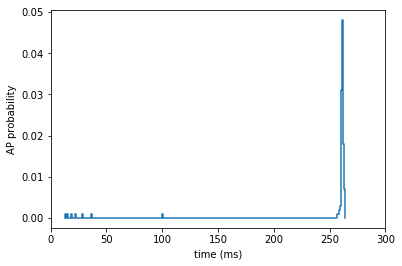

In [125]:
# the sensory sitmulus was always applied at 245 ms
ax = plt.gca()
histogram(temporal_binning_pd(st_reformat), fig = ax)
plt.ylabel('AP probability')
plt.xlabel('time (ms)')
plt.xlim(0, 300)

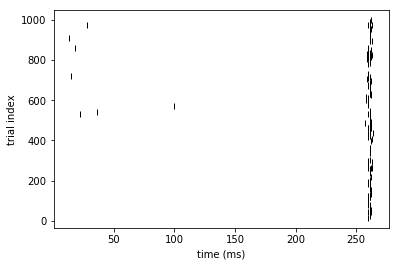

In [126]:
ax = plt.gca()
rasterplot(st_reformat, fig = ax)
plt.xlabel('time (ms)')
plt.ylabel('trial index')